<a href="https://colab.research.google.com/github/jrohn34/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Product Sales

- Author: Josh Rohn

## Project Overview

## Load and Inspect Data

In [31]:
import pandas as pd

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
fname = '/content/drive/MyDrive/sales_predictions_2023.csv'

In [34]:
df = pd.read_csv(fname)

In [35]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


1: 12 columns and 8522 rows

In [37]:
variable_dtypes = df.dtypes

print(variable_dtypes)

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object


## Clean Data

In [38]:
duplicates = df.duplicated()
print("Number of duplicates:", duplicates.sum())

df.drop_duplicates(inplace=True)

Number of duplicates: 0


In [39]:
missing_values = df.isnull().sum()

print(missing_values)

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [40]:
numerical_placeholder = -1
categorical_placeholder = 'Missing'

numerical_columns = ['Item_Weight']
categorical_columns = ['Outlet_Size']

df_filled = df.copy()

df_filled[numerical_columns] = df_filled[numerical_columns].fillna(numerical_placeholder)

df_filled[categorical_columns] = df_filled[categorical_columns].fillna(categorical_placeholder)

print("DataFrame after addressing missing values:")
print(df_filled.head())

DataFrame after addressing missing values:
  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2               

In [41]:
missing_values = df_filled.isna().sum()
print("Missing values:")
print(missing_values)

Missing values:
Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


In [42]:
numerical_columns = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']

summary_statistics = df_filled[numerical_columns].describe()

print(summary_statistics)

       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  8523.000000      8523.000000  8523.000000                8523.000000   
mean     10.478936         0.066132   140.992782                1997.831867   
std       6.720742         0.051598    62.275067                   8.371760   
min      -1.000000         0.000000    31.290000                1985.000000   
25%       6.650000         0.026989    93.826500                1987.000000   
50%      11.000000         0.053931   143.012800                1999.000000   
75%      16.000000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800  


## Exploratory Data Analysis

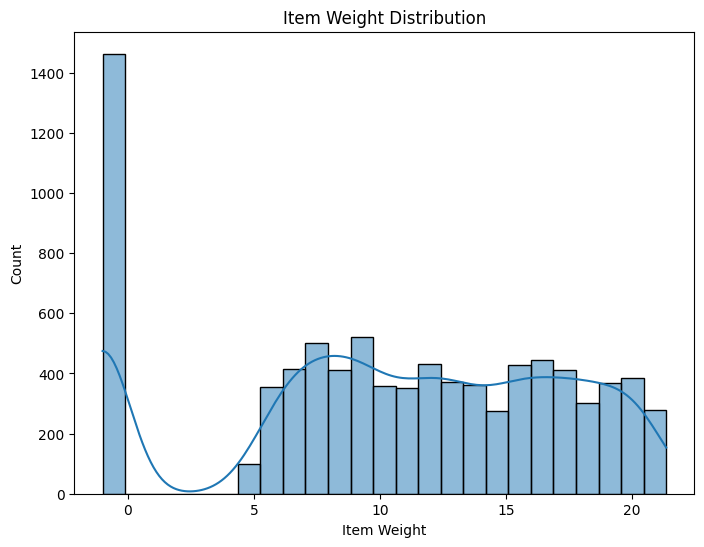

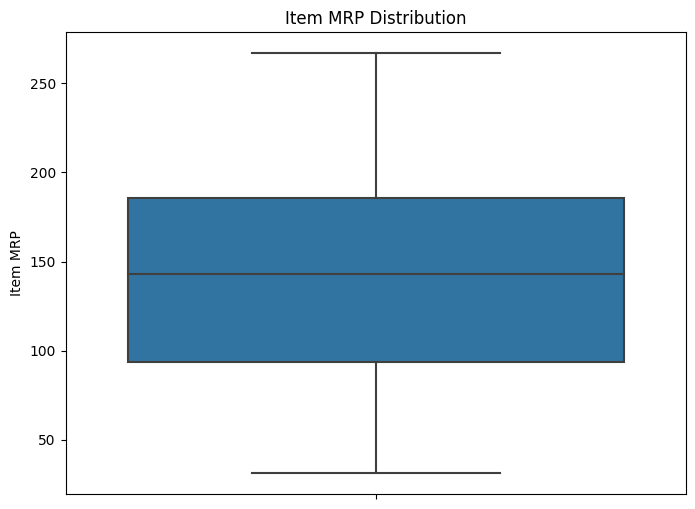

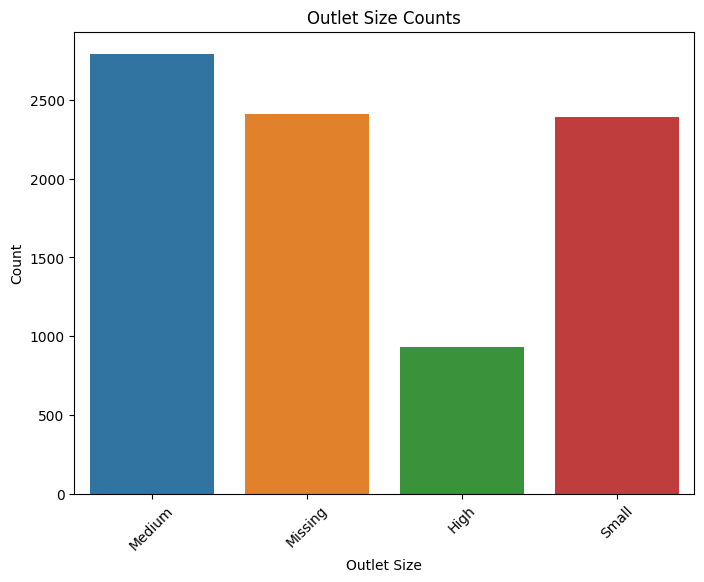

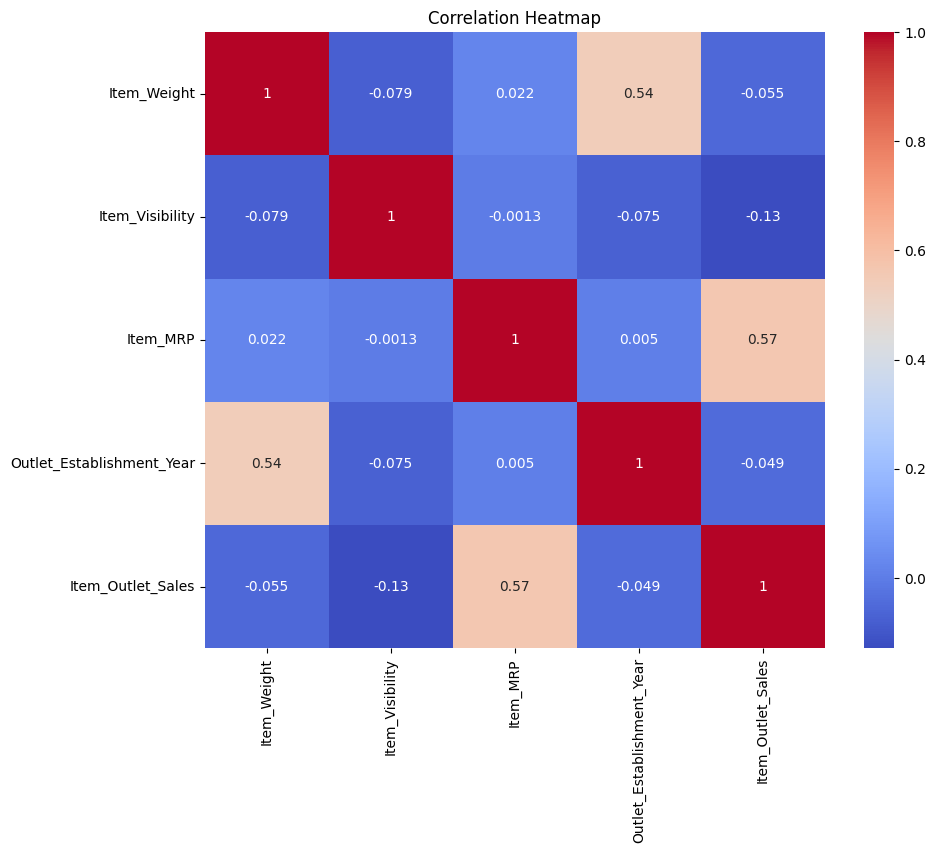

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram for a numerical feature
plt.figure(figsize=(8, 6))
sns.histplot(df_filled['Item_Weight'], kde=True)
plt.title('Item Weight Distribution')
plt.xlabel('Item Weight')
plt.ylabel('Count')
plt.show()

# Boxplot for a numerical feature
plt.figure(figsize=(8, 6))
sns.boxplot(y=df_filled['Item_MRP'])
plt.title('Item MRP Distribution')
plt.ylabel('Item MRP')
plt.show()

# Countplot for a categorical feature
plt.figure(figsize=(8, 6))
sns.countplot(data=df_filled, x='Outlet_Size')
plt.title('Outlet Size Counts')
plt.xlabel('Outlet Size')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Heatmap for correlation between features
plt.figure(figsize=(10, 8))
sns.heatmap(df_filled[numerical_columns].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

You can actually loop  through all of the graphs using the enumerate function I learned it in one of  my classes at school.

## Feature Inspection